<a href="https://colab.research.google.com/github/shantanutrip/covid_flight_analysis/blob/master/Analysis/flight_helps_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook aims to discover how air travel helped the spread of COVID-19 

# Install dependencies

In [1]:
# Install spark-related dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

     |████████████████████████████████| 217.8MB 51kB/s 
     |████████████████████████████████| 204kB 42.4MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=68cb2e401b2b63e75dcf2bbf92a7d608690edc312d5994ba05a4c6dfa51f08ba
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


# Download data



In [2]:
!wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
!wget https://ourairports.com/data/airports.csv

--2020-05-08 09:54:19--  https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4745409 (4.5M) [text/plain]
Saving to: ‘us-counties.csv’

us-counties.csv     100%[===================>]   4.53M  17.9MB/s    in 0.3s    

2020-05-08 09:54:19 (17.9 MB/s) - ‘us-counties.csv’ saved [4745409/4745409]

--2020-05-08 09:54:20--  https://ourairports.com/data/airports.csv
Resolving ourairports.com (ourairports.com)... 206.71.179.167
Connecting to ourairports.com (ourairports.com)|206.71.179.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8475762 (8.1M) [text/csv]
Saving to: ‘airports.csv’

airports.csv        100%[===================>]   8.08M  9.78MB/s    in 0.8s    

2020-

# Execution 

In [0]:
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

airports = spark.read.format("csv").options(header="true").load("/content/airports.csv")
disease = spark.read.format("csv").options(header="true", inferSchema="true").load("/content/us-counties.csv")
# Change merged_flight.csv path accordingly
all_flights = spark.read.format("csv").options(header="true", inferSchema="true").load("/content/drive/My Drive/Big Data Final Project/Data/merged_flight.csv")

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import datetime
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# Select target city and state.
target_city = "Dallas"
target_state = "Texas"

In [55]:
# Finding out when COVID-19 started spreading in target city.
target_date = disease.filter((disease["county"] == target_city) & (disease["state"] == target_state)).orderBy("date").first()["date"]
print(target_date)

2020-03-10 00:00:00


In [56]:
# Finding out the airports' ICAO code and name for the target city.
target_airports = airports.filter((airports["municipality"] == target_city) & ((airports["type"] == "large_airport") | (airports["type"] == "medium_airport"))).select("ident", "name", "municipality")
target_airports.show()

+-----+-----------------+------------+
|ident|             name|municipality|
+-----+-----------------+------------+
| KDAL|Dallas Love Field|      Dallas|
+-----+-----------------+------------+



In [57]:
# Finding out all flights that landed in target city(county) in the first 4 months of 2020.
target_flights = all_flights.filter(all_flights["origin"] != "null").join(target_airports, target_airports["ident"] == all_flights["destination"]).withColumnRenamed("ident", "dst_ident").withColumnRenamed("name", "dst_name").withColumnRenamed("municipality", "dst_municipality").drop("callsign", "number", "icao24", "registration", "typecode", "firstseen", "lastseen")
target_flights.show()

+------+-----------+--------------------+---------+-----------------+----------------+
|origin|destination|                 day|dst_ident|         dst_name|dst_municipality|
+------+-----------+--------------------+---------+-----------------+----------------+
|  KFLL|       KDAL|2020-01-01 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|  KLGA|       KDAL|2020-01-01 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|  KLAS|       KDAL|2020-01-01 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|  KSEA|       KDAL|2020-01-01 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|  KDCA|       KDAL|2020-01-01 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|  KSEA|       KDAL|2020-01-01 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|  KBWI|       KDAL|2020-01-01 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|  KPHL|       KDAL|2020-01-01 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|  KSJC|       KDAL|2020-01-01 00:00:...|  

In [58]:
# Adding origin airport information (ident, name, municipality, latitude, longitude).
target_flights = airports.select("ident", "name", "municipality", "latitude_deg", "longitude_deg").join(target_flights, target_flights["origin"] == airports["ident"]).withColumnRenamed("ident", "src_ident").withColumnRenamed("name", "src_name").withColumnRenamed("municipality", "src_municipality")
target_flights.show()

+---------+--------------------+----------------+------------------+-------------------+------+-----------+--------------------+---------+-----------------+----------------+
|src_ident|            src_name|src_municipality|      latitude_deg|      longitude_deg|origin|destination|                 day|dst_ident|         dst_name|dst_municipality|
+---------+--------------------+----------------+------------------+-------------------+------+-----------+--------------------+---------+-----------------+----------------+
|     KFLL|Fort Lauderdale H...| Fort Lauderdale|         26.072599|         -80.152702|  KFLL|       KDAL|2020-01-01 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|     KLGA|  La Guardia Airport|        New York|       40.77719879|       -73.87259674|  KLGA|       KDAL|2020-01-01 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|     KLAS|McCarran Internat...|       Las Vegas|       36.08010101|       -115.1520004|  KLAS|       KDAL|2020-01-01 00:00:...|  

In [0]:
# Filtering function definition  
def date_filter(day):
  '''
  This filter checks if input date is in the two weeks range prior of the target date. 
  '''
  datetime_obj = datetime.datetime.strptime(day.split("+")[0], "%Y-%m-%d %H:%M:%S")
  two_weeks = datetime.timedelta(days=14)
  zero = datetime.timedelta(days=0)
  day_difference = target_date - datetime_obj
  if day_difference <= two_weeks and day_difference > zero:
    return True
  return False

filter_func = udf(date_filter, BooleanType())

In [60]:
# Filtering flights that are in the two weeks range prior of the spread in target city.
target_flights = target_flights.filter(filter_func(target_flights["day"]))
target_flights.show()

+---------+--------------------+----------------+------------------+-----------------+------+-----------+--------------------+---------+-----------------+----------------+
|src_ident|            src_name|src_municipality|      latitude_deg|    longitude_deg|origin|destination|                 day|dst_ident|         dst_name|dst_municipality|
+---------+--------------------+----------------+------------------+-----------------+------+-----------+--------------------+---------+-----------------+----------------+
|     KLGA|  La Guardia Airport|        New York|       40.77719879|     -73.87259674|  KLGA|       KDAL|2020-02-25 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|     KDCA|Ronald Reagan Was...|      Washington|           38.8521|       -77.037697|  KDCA|       KDAL|2020-02-25 00:00:...|     KDAL|Dallas Love Field|          Dallas|
|     KSEA|Seattle Tacoma In...|         Seattle|         47.449001|      -122.308998|  KSEA|       KDAL|2020-02-25 00:00:...|     KDAL|Dall

In [61]:
# Grouping all flights by origin city and county, sort by count in descending order.
incoming_flight_info = target_flights.groupBy("src_municipality", "latitude_deg", "longitude_deg").count().orderBy(desc("count"))
incoming_flight_info.show()

+----------------+------------------+-------------------+-----+
|src_municipality|      latitude_deg|      longitude_deg|count|
+----------------+------------------+-------------------+-----+
|         Houston|       29.64539909|       -95.27890015|  224|
|         Atlanta|           33.6367|         -84.428101|  151|
|     San Antonio|         29.533701|         -98.469803|  141|
|          Austin|30.194499969482422|  -97.6698989868164|  140|
|       Las Vegas|       36.08010101|       -115.1520004|  120|
|          Denver|   39.861698150635|     -104.672996521|  115|
|     Los Angeles|         33.942501|        -118.407997|  109|
|         Chicago|         41.785999|         -87.752403|  102|
|         Phoenix| 33.43429946899414|-112.01200103759766|   95|
|        St Louis|         38.748697|         -90.370003|   90|
|     Kansas City|           39.2976|         -94.713898|   87|
|       Baltimore|           39.1754|         -76.668297|   68|
|       Nashville|  36.1245002746582|  -

In [0]:
# Function definition for adding county column
geolocator = Nominatim(user_agent = "flights_analysis", timeout=100)

def add_county(lat, lng):
  '''
  This function adds county column to caller dataframe
  '''
  geo_str = str(lat) + ", " + str(lng)
  location = geolocator.reverse(geo_str).raw
  try:
    county_full = location["address"]["county"]
    county = " ".join(county_full.split(" ")[:-1])
    return county
  except KeyError:
    return "null"

def add_state(lat, lng):
  '''
  This function adds state column to caller dataframe
  '''
  geo_str = str(lat) + ", " + str(lng)
  location = geolocator.reverse(geo_str).raw
  try:
    state = location["address"]["state"]
    return state
  except KeyError:
    return "null"

add_county_func = udf(add_county, StringType())
add_state_func = udf(add_state, StringType())

In [0]:
# Adding county column
incoming_flight_info = incoming_flight_info.withColumn("county", add_county_func(incoming_flight_info["latitude_deg"], incoming_flight_info["longitude_deg"])).withColumn("state", add_state_func(incoming_flight_info["latitude_deg"], incoming_flight_info["longitude_deg"]))
# Extract key information
key_info = incoming_flight_info.groupBy("county", "state").sum("count").collect()

In [65]:
# Reconstruct dataframe to avoid long processing time of adding state and county column
key_info_df = spark.createDataFrame(key_info).orderBy(desc("sum(count)"))
key_info_df.show()

+------------+----------+----------+
|      county|     state|sum(count)|
+------------+----------+----------+
|      Harris|     Texas|       226|
|     Clayton|   Georgia|       151|
|       Bexar|     Texas|       144|
|      Travis|     Texas|       140|
| Los Angeles|California|       123|
|       Clark|    Nevada|       120|
|      Denver|  Colorado|       115|
|        Cook|  Illinois|       103|
|    Maricopa|   Arizona|        96|
| Saint Louis|  Missouri|        90|
|      Platte|  Missouri|        87|
|Anne Arundel|  Maryland|        68|
|    Davidson| Tennessee|        66|
|  Bernalillo|New Mexico|        65|
|      Queens|  New York|        64|
|   Arlington|  Virginia|        63|
|   San Diego|California|        57|
|        King|Washington|        55|
|       Tulsa|  Oklahoma|        52|
|     Broward|   Florida|        50|
+------------+----------+----------+
only showing top 20 rows



In [66]:
# Finding out when COVID-19 started spreading in each county
spread_start = disease.orderBy("date").groupBy("county", "state").agg(first("date")).withColumnRenamed("county", "spread_county").withColumnRenamed("state", "spread_state").withColumnRenamed("first(date, false)", "start_date")
spread_start.show()

+-------------+--------------+-------------------+
|spread_county|  spread_state|         start_date|
+-------------+--------------+-------------------+
|      Pulaski|      Arkansas|2020-03-12 00:00:00|
|       Orange|       Florida|2020-03-13 00:00:00|
|       Mercer|    New Jersey|2020-03-14 00:00:00|
|   Winneshiek|          Iowa|2020-03-18 00:00:00|
|   Washington|       Alabama|2020-03-20 00:00:00|
|      Pickens|       Georgia|2020-03-20 00:00:00|
|      Chisago|     Minnesota|2020-03-20 00:00:00|
|        Grant|     Louisiana|2020-03-23 00:00:00|
|   Pennington|  South Dakota|2020-03-23 00:00:00|
|        Stone|      Arkansas|2020-03-24 00:00:00|
|    Claiborne|     Tennessee|2020-03-24 00:00:00|
|         Iron|     Wisconsin|2020-03-27 00:00:00|
|    Covington|   Mississippi|2020-03-28 00:00:00|
|    Henderson|         Texas|2020-03-29 00:00:00|
|       Sumter|       Alabama|2020-03-30 00:00:00|
|   Washington|         Idaho|2020-04-02 00:00:00|
|       Murray|      Oklahoma|2

In [67]:
# Join spread_start and incoming_flight_info
key_info_df = key_info_df.join(spread_start, (key_info_df["county"]==spread_start["spread_county"]) &(key_info_df["state"]==spread_start["spread_state"])).drop("spread_county", "spread_state")
key_info_df.show()

+------------+----------+----------+-------------------+
|      county|     state|sum(count)|         start_date|
+------------+----------+----------+-------------------+
|      Harris|     Texas|       226|2020-03-05 00:00:00|
|     Clayton|   Georgia|       151|2020-03-15 00:00:00|
|       Bexar|     Texas|       144|2020-02-12 00:00:00|
|      Travis|     Texas|       140|2020-03-13 00:00:00|
| Los Angeles|California|       123|2020-01-26 00:00:00|
|       Clark|    Nevada|       120|2020-03-05 00:00:00|
|      Denver|  Colorado|       115|2020-03-06 00:00:00|
|        Cook|  Illinois|       103|2020-01-24 00:00:00|
|    Maricopa|   Arizona|        96|2020-01-26 00:00:00|
|      Platte|  Missouri|        87|2020-03-25 00:00:00|
|Anne Arundel|  Maryland|        68|2020-03-13 00:00:00|
|    Davidson| Tennessee|        66|2020-03-08 00:00:00|
|  Bernalillo|New Mexico|        65|2020-03-11 00:00:00|
|   Arlington|  Virginia|        63|2020-03-11 00:00:00|
|   San Diego|California|      

In [0]:
# Function definition for adding day difference with target date
def add_day_difference(day):
  '''
  This function adds day difference between target date and input date
  '''
  day_difference = target_date - day
  return day_difference.days

add_difference_func = udf(add_day_difference, IntegerType())

In [69]:
# Adding day difference column to dataframe
key_info_df = key_info_df.withColumn("day_difference", add_difference_func(key_info_df["start_date"]))
key_info_df.show()

+------------+----------+----------+-------------------+--------------+
|      county|     state|sum(count)|         start_date|day_difference|
+------------+----------+----------+-------------------+--------------+
|      Harris|     Texas|       226|2020-03-05 00:00:00|             5|
|     Clayton|   Georgia|       151|2020-03-15 00:00:00|            -5|
|       Bexar|     Texas|       144|2020-02-12 00:00:00|            27|
|      Travis|     Texas|       140|2020-03-13 00:00:00|            -3|
| Los Angeles|California|       123|2020-01-26 00:00:00|            44|
|       Clark|    Nevada|       120|2020-03-05 00:00:00|             5|
|      Denver|  Colorado|       115|2020-03-06 00:00:00|             4|
|        Cook|  Illinois|       103|2020-01-24 00:00:00|            46|
|    Maricopa|   Arizona|        96|2020-01-26 00:00:00|            44|
|      Platte|  Missouri|        87|2020-03-25 00:00:00|           -15|
|Anne Arundel|  Maryland|        68|2020-03-13 00:00:00|        

In [70]:
# We only care about the counties that had the virus before target date
key_info_df = key_info_df.filter(key_info_df["day_difference"] > 0)
key_info_df.show()

+------------+--------------+----------+-------------------+--------------+
|      county|         state|sum(count)|         start_date|day_difference|
+------------+--------------+----------+-------------------+--------------+
|      Harris|         Texas|       226|2020-03-05 00:00:00|             5|
|       Bexar|         Texas|       144|2020-02-12 00:00:00|            27|
| Los Angeles|    California|       123|2020-01-26 00:00:00|            44|
|       Clark|        Nevada|       120|2020-03-05 00:00:00|             5|
|      Denver|      Colorado|       115|2020-03-06 00:00:00|             4|
|        Cook|      Illinois|       103|2020-01-24 00:00:00|            46|
|    Maricopa|       Arizona|        96|2020-01-26 00:00:00|            44|
|    Davidson|     Tennessee|        66|2020-03-08 00:00:00|             2|
|   San Diego|    California|        57|2020-02-10 00:00:00|            29|
|        King|    Washington|        55|2020-02-28 00:00:00|            11|
|       Tuls

In [71]:
# Add case number for each county on the target date
key_info_df = key_info_df.withColumnRenamed("county", "k_county").withColumnRenamed("state", "k_state")
key_info_df = key_info_df.join(disease, (key_info_df["k_county"]==disease["county"]) & (key_info_df["k_state"]==disease["state"]) & (disease["date"]==target_date)).select("county", "state", "sum(count)", "start_date", "day_difference", "cases")
key_info_df.show()

+------------+--------------+----------+-------------------+--------------+-----+
|      county|         state|sum(count)|         start_date|day_difference|cases|
+------------+--------------+----------+-------------------+--------------+-----+
|      Harris|         Texas|       226|2020-03-05 00:00:00|             5|    7|
|       Bexar|         Texas|       144|2020-02-12 00:00:00|            27|   11|
| Los Angeles|    California|       123|2020-01-26 00:00:00|            44|   20|
|       Clark|        Nevada|       120|2020-03-05 00:00:00|             5|    2|
|      Denver|      Colorado|       115|2020-03-06 00:00:00|             4|    4|
|        Cook|      Illinois|       103|2020-01-24 00:00:00|            46|   17|
|    Maricopa|       Arizona|        96|2020-01-26 00:00:00|            44|    2|
|    Davidson|     Tennessee|        66|2020-03-08 00:00:00|             2|    1|
|   San Diego|    California|        57|2020-02-10 00:00:00|            29|    2|
|        King|  

# Visualization

In [0]:
# Collecting information
county_state_info = key_info_df.select("county", "state").collect()
flight_count_info = key_info_df.select("sum(count)").collect()
day_difference_info = key_info_df.select("day_difference").collect()
case_number_info = key_info_df.select("cases").collect()

In [0]:
# Covert lists of rows to lists of primitives
county_state_list = [row["county"]+","+row["state"] for row in county_state_info]
flight_count_list = [row["sum(count)"] for row in flight_count_info]
day_difference_list = [row["day_difference"] for row in day_difference_info]
case_number_list = [row["cases"] for row in case_number_info]

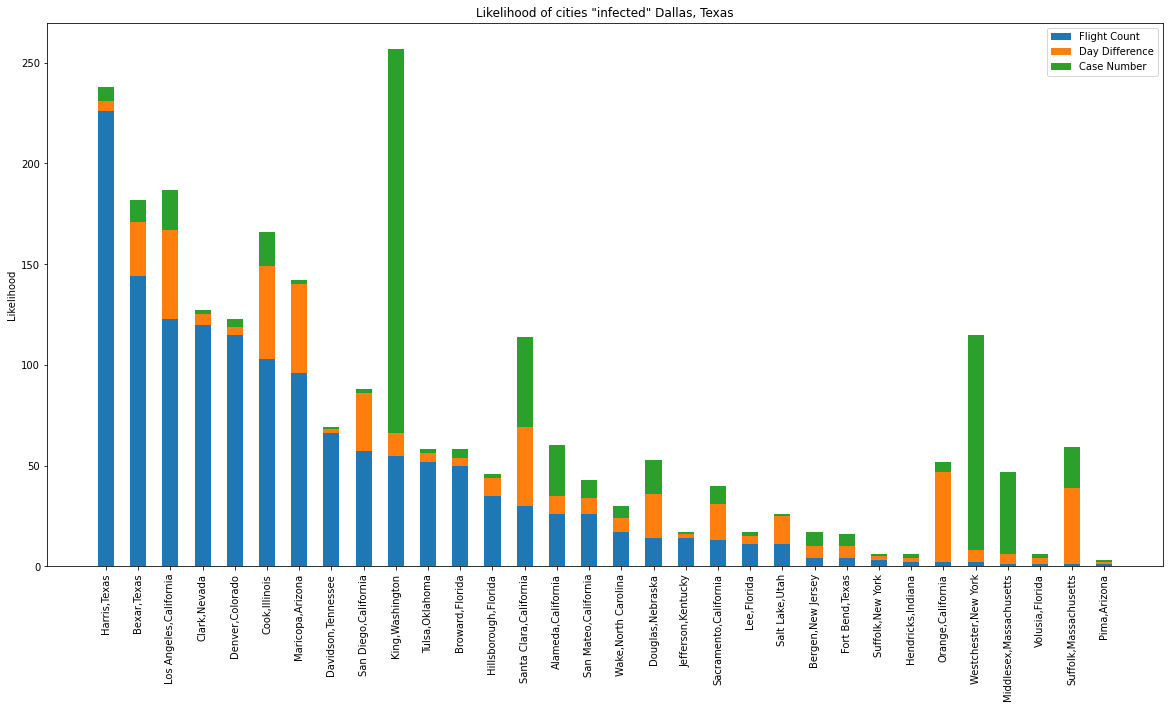

In [74]:
# Generate stacked bar graph
bar_width = 0.5
fig, ax = plt.subplots(figsize=(20, 10))

both_bars = np.add(flight_count_list, day_difference_list).tolist()

ax.bar(county_state_list, flight_count_list, bar_width, label='Flight Count')
ax.bar(county_state_list, day_difference_list, bar_width, bottom = flight_count_list, label='Day Difference')
ax.bar(county_state_list, case_number_list, bar_width, bottom = both_bars, label='Case Number')

ax.set_ylabel('Likelihood')
ax.set_title('Likelihood of cities "infected" ' + target_city + ", " + target_state)
ax.legend()

for ax in fig.axes:
  plt.sca(ax)
  plt.xticks(rotation=90)

# Conclusion

As stated at the beginning of this notebook, we are trying to determine how air travel helped the spread of COVID-19. More specifically, we want to be able to select a random city, analyze its incoming flights and determine which county could possibly "infected" the selected city. For decision making, we took three factor into account:

*   Amount of incoming flight during the two weeks before COVID-19 started spreading in target city (we will call these two weeks ***target weeks***). Reason being that the probability of infectants traveled to target city increases as the amount of incoming flight increases.
*   Day difference between spread start date at the target city and spread start date for each county that had flights arrived at target city (we will call these counties ***target county***) during the ***target weeks***. Reason being that a larger date difference means more travelers, therefore the probability of infectants traveled to target city increases. 
*   COVID-19 case number of each ***target county*** on the target date. Reason being that as the case number increases, the probability of infectants traveled to target city increases.

For illustration putposes, we selected Dallas Texas as an example. From the graph above, we can see that there were lots of flights came to Dallas from the county of Harris in Texas, however, the value of day difference and case number is relatively small. Therefore, it is less likely that Harris county "infected" Dallas. Take a look at the county of King in Washington, the value of case number is sky high, and the day difference is larger than it was for Harris, even though it has less flights coming to Dallas, it is safe to claim that the county of King in Washington might have helped the spread of COVID-19 in Dallas, at least more than the county of Harris did. 

Please note that there are tons of factors that facilitated the spread of COVID-19 in the United States, this experiment only attempted to analyze the potential influence of domestic flights. Therefore, the result of this experiment cannot be used to fully explain how COVID-19 was spread to target city.




# Possible Further Improvement

Currently, we simply added up the value of the three factor mentioned above for each ***target county***, however, we think a weighted sum could better reflect the influence of each ***target county***. However, to determine the weight for each factor, further researches and experiments are necessary. 
